In [165]:
# Imports here
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
# Dataset here
file = open("../dataset/processed_reviews.json", 'r', encoding='utf8')
dataset_dict = json.load(file)
df_raw = pd.DataFrame(dataset_dict)

In [167]:
# Unused features
df = df_raw.copy(deep=True) #Do this so that I dont have to rerun the previous cell every time I make a change
df.drop(columns=['firm','job_title', 'current', 'headline', 'pros', 'cons', 'duration'], inplace=True)

# Split up Date
df['date'] = pd.to_datetime(df['date_review'])
df['month'] = df['date'].dt.month.astype(str)
df['year'] = df['date'].dt.year

# Min-max normalization
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#One hot encode
one_hot_encoded = pd.get_dummies(df[['recommend', 'ceo_approv', 'outlook', 'month']])
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['date', 'date_review', 'recommend', 'ceo_approv', 'outlook', 'month'], inplace=True)

df.head()

,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,year,recommend_o,recommend_v,recommend_x,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0.25,0.50,0.00,0.25,0.0,0.75,0.538462,False,False,True,...,False,True,False,False,False,False,False,False,False,False
1,0.00,0.00,0.00,0.00,0.0,0.00,0.615385,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0.00,0.25,0.00,0.25,0.0,0.00,0.615385,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,0.50,0.75,0.25,0.25,0.5,0.25,0.615385,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.00,0.00,0.00,0.00,0.0,0.00,0.615385,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [168]:
#Spliting the data
X = df.drop(columns=['overall_rating'])
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [169]:
def buildSigmoidPerceptron():
    model = Sequential([
        Dense(1, activation = 'sigmoid', input_dim = X.shape[1]),
    ])
    optimizer = SGD(learning_rate=0.3)
    model.compile(optimizer=optimizer, loss='mse', metrics=['MSE'])
    return(model)

estimator = KerasRegressor(model=buildSigmoidPerceptron, epochs=10, batch_size=1000, verbose=0)
history = estimator.fit(X_train, y_train, validation_data=(X_test.astype('float'), y_test))
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)
pd.DataFrame(y_test_pred)

,0
0,0.227357
1,0.517102
2,0.693499
3,0.942012
4,0.254110
...,...
75735,0.647802
75736,0.910692
75737,0.916903
75738,0.928657


# MSE # 

In [170]:
MSE = sum((y_test_pred - y_test)**2)/y_test.size
print(MSE)

0.030955257312464006


In [171]:
# Fraction of Variance Unexplained
FVU = MSE/np.var(y_test)
print(FVU)

0.35827007227959573


In [172]:
# Training vs Test Error
train_error = sum((y_train_pred - y_train)**2)/y_train.size
test_error = sum((y_test_pred - y_test)**2)/y_test.size

print('Train Error:', train_error)
print('Test Error:', test_error)

train_fvu = train_error/np.var(y_train)
test_fvu = test_error/np.var(y_test)

print('Train FVU:', train_fvu)
print('Test FVU:', test_fvu)

Train Error: 0.03075444619881857
Test Error: 0.030955257312464006
Train FVU: 0.35436033236030245
Test FVU: 0.35827007227959573


# Classification Metrics #
# Accuracy, Precision, Recall #

In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def threshold(predictions):
    thresholds = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
    values = [1, 2, 3, 4, 5]
    
    result = np.zeros_like(predictions)
    for i in range(len(thresholds) - 1):
        result[(predictions >= thresholds[i]) & (predictions < thresholds[i+1])] = values[i]
    
    return result

test_copy = np.copy(y_test)
rate = [(1, 5), (0, 1), (0.25, 2), (0.5, 3), (0.75, 4)]
for (t, r) in rate: test_copy[test_copy == t] = r

y_test_pred_thresholded = threshold(y_test_pred)
y_test_thresholded = test_copy

print(np.unique(y_test_pred_thresholded))
print(np.unique(y_test_thresholded))

accuracy = accuracy_score(y_test_thresholded, y_test_pred_thresholded)

precision = precision_score(y_test_thresholded, y_test_pred_thresholded, average='weighted', zero_division=0)

recall = recall_score(y_test_thresholded, y_test_pred_thresholded, average='weighted', zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]
Accuracy: 0.5338526538156853
Precision: 0.5449178518570276
Recall: 0.5338526538156853


<ul>
<li>Accuracy: 0.5338526538156853</li>
<li>Precision: 0.5449178518570276</li>
<li>Recall: 0.5338526538156853</li>
</ul>

# Where does our model sit on the Fitting graph? # 

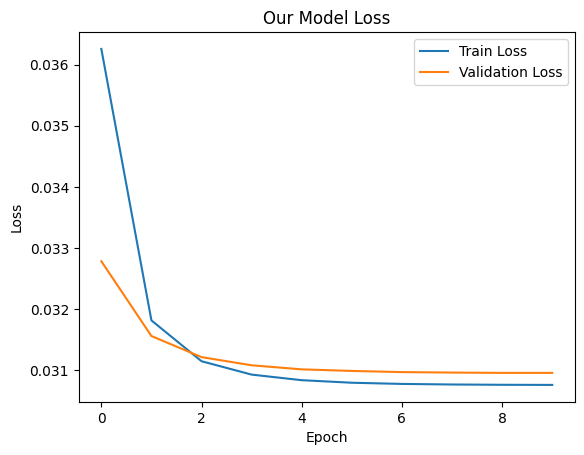

In [174]:
plt.plot(history.history_['loss'], label='Train Loss')
plt.plot(history.history_['val_loss'], label='Validation Loss')
plt.title(f'Our Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Given our test and train errors are very close to each other (Train MSE: 0.0307 vs. Test MSE: 0.0309 and Train FVU: 0.3543 vs. Test FVU: 0.3582), we know that our model is not overfitting. However, since our test and train errors are relatively high and the accuracy of our model is only 0.5338, we know that there is much room for improvement and indicates that our model is underfitting. 

# Confusion Matrix # 

Confusion Matrix:
[[ 3301  1240   317   421    26]
 [ 1393  3121  1282   801    23]
 [  304  2661  5116  8486   843]
 [   28   274  1396 13373  9915]
 [   28    82   193  5593 15523]]


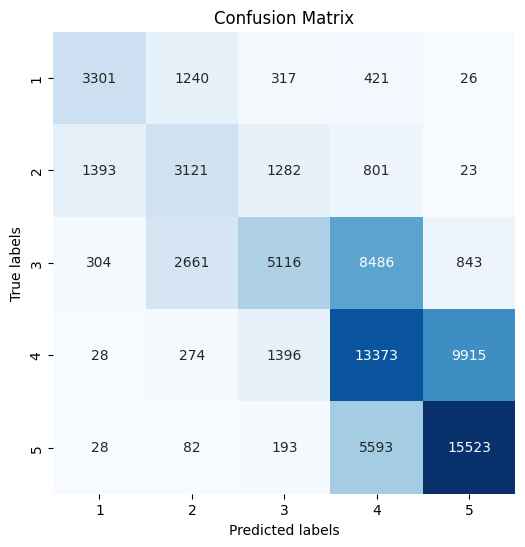

In [175]:
cm = confusion_matrix(y_test_thresholded, y_test_pred_thresholded)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

|        | Class 1 | Class 2 | Class 3 | Class 4 | Class 5 |
|--------|---------|---------|---------|---------|---------|
| Class 1|   3301  |   1240  |  317    |   421   |    26   |
| Class 2|   1393  |  3121   |  1282   |   801   |    23   |
| Class 3|   304   |  2661   |  5116   |  8486   |   843   |
| Class 4|    28   |   274   |  1396   | 13373   |  9915   |
| Class 5|    28   |   82    |  193    |  5593   | 15523   |


# Next two models #